<div class="alert alert-info"> 
<h3>TASK</h3>
<br>
<b>With a dataset contains the transaction history of an online store that sells household goods, I was assigned to analyze the product range.</b>
<br>
<br>The given dataset had easy to understand field names, but there was no further explanation regarding the nature and quality of the data.
<br><b>Products had short description names but were not labeled or categorized.</b> There were also mixed non-commerce transaction records.
<br>Therefore, dataset was checked and cleaned carefully in the preparation step <a href="#part_1">[Part_1 Data Overview and Preprocessing]</a>
</div>

<div class="alert alert-warning">
<h3>APPROACH</h3>
<br>
<b>The key methods used for this project consisted of: keywords extractions, RFM models, Kmeans clustering and statistical proportion Z-test</b>
<br>
<br><b>With different techniques in handling text data, keywords coud be extracted from product descriptions and used as alternative product labels.</b>
<br>Each product was defined by a set of keywords (multi-label) and could also be grouped based on shared keywords <a href="#part_2">[Part_2 Product Description Analysis]</a>
<br>
<br>The "recency" - "frequency" – "monetary" (RFM) model, which often known in customer segmentation, was used to evaluate product market values in similar manner. The metrics showed "how recent", "how often" and "how much" a product was purchased. <b>With RFM model, products could be classified into different value groups using Kmeans clustering or manual adjustment of segment boundaries.</b>
<br>
<br>However, classification alone is not enough. We want to know which "general types" of products are more likely to be “good value” or “bad value”.
<br>In another words, which keyword are more or less likely to appear in which groups?
<br>For this, <b>the proportion of keywords in specific groups were compared with the general proportion of keywords in the total dataset and statistical test were used to detect significant differences.</b><a href="#part_3">[Part_3 Product Market Value Analysis]</a>
<br>
<br>Similarly, <b>order invoices could also be grouped and product proportions in each group could be compared.</b> This “basket analysis” helped identify which products are more or less likely to be bought alone or together with other products. </b><a href="#part_4">[Part_4 Product Bundle Analysis of Recent Invoices]</a>
</div>

<div class="alert alert-success">
<h3>RESULT</h3>
<br>
<b>The study provided valid grounds for targeted adjustments to boost sales and revenue based on customer preference and behaviour.</b><a href="#part_6">[Part_6 Summary and Suggestions]</a>
<br>
<h4>EXTRA:</h4>
<a href="https://drive.google.com/file/d/1u_x9h8qcRtPSnmyUfgWEbHKEhNgGBswM/view?usp=sharing">Presentation</a> - a short report summarized the analysis results
<br>
<a href="https://demoproject.streamlit.app/">Interactive tool</a> - a product clustering app created for the project
</div>

# PROJECT: E-Commerce Product Range Analysis
### TASK: 
You have a dataset contains the transaction history of an online store that sells household goods. Create an overall view of the range of products.

### TABLE OF CONTENT:

* [PART_1> DATA OVERVIEW AND PREPROCESSING](#part_1)  

    + Data Overview  

    + Check missing, duplicated, abnormal data  and variable relationship  
    
    + Data preprocessing and calculation  
    

* [PART_2> PRODUCT DESCRIPTION ANALYSIS](#part_2)  

    + Keywords Identification  

    + Keywords Analysis  

    + Product Groupping by Keywords


* [PART_3> PRODUCT MARKET VALUE ANALYSIS](#part_3)  

    + Product Metrics

    + Product KMeans Clustering

    + Other Product Groups 


* [PART_4> PRODUCT BUNDLE ANALYSIS OF RECENT INVOICES](#part_4)  

    + Invoice Metrics  

    + Invoice KMeans Clustering

    + Product Correlation


* [PART_5> RETURN RATE COMPARISION](#part_5)  
    

* [PART_6> SUMMARY AND SUGGESTIONS](#part_6) 

---
---

In [1]:
# IMPORT PACKAGES USED FOR PROJECT-------------------------------------------------#
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



# GENERAL SETUP -------------------------------------------------------------------#
seed = 2021
path = '/datasets/'
os.chdir(path)
pd.options.display.max_colwidth = 300
q=[0.01, 0.05, 0.25, 0.75, 0.95, 0.99]

stop_words = stopwords.words('english')

# LIST OF FUNCTIONS USED FOR PROJECT-----------------------------------------------#

def Breakline(n=100):
    print()
    print('-'*n)
    print()


def NaN_Columns(df):
    return df.columns[df.isnull().any()].tolist()


def Simple_String(string, case=None, remove=['extra_space']):
    """
    This function simplify a string by setting upper/lower case, removing symbol/number/space/extra space.
    """
    try:
        if case == 'lower':
            string = string.lower()
        elif case == 'upper':
            string = string.upper()

        if 'symbol' in remove:
            from string import punctuation
            string = string.translate({ord(i): None for i in punctuation})

        if 'letter' in remove:
            string = ''.join(i for i in string if not i.isalpha())
        
        if 'number' in remove:
            string = ''.join(i for i in string if not i.isdigit())

        if 'space' in remove:
            string = string.replace(' ','')

        if 'extra_space' in remove:
            string = (' '.join(string.split())).strip()
        
        return string.strip()
    
    except:
        return float('NaN')


def Subset_Size(df, cond, unique=None):
    try:
        if unique:
            return(str(df[cond][unique].nunique()) + ' ({:.1%})'.format(df[cond][unique].nunique()/df[unique].nunique()))
        
        else:
            return(str(len(df[cond])) + ' ({:.2%})'.format(len(df[cond])/len(df)))
    except:
        return ('Error')


def Subset_Distribution (df, cond={}, unique=[]):
    report = {}
    for key in cond.keys():
        report[key] = [Subset_Size(df, cond[key])]

        for var in unique:
            report[key].append(Subset_Size(df, cond[key], unique=var))
    unique.insert(0,'total')
    
    return pd.DataFrame(report, index=unique)


def Check_Unique(df, col1, col2, report=True, normalize=False):
    count = df.groupby(col1)[col2].nunique()

    if report:
        table = count.value_counts(normalize=normalize).reset_index().sort_values('index')
        if normalize:
            table.columns = ['nunique_'+ col2, 'proportion']
        else:
            table.columns = ['nunique_'+ col2, 'count']
        display(table)
    
    return count


def Most_Common_Value (list, error= float('NaN')):
    try:
        return list.value_counts().index[0]
    except:
        return error


def Find_Keyword(data, n=1, lem=False, filter=[]):
    """
    This function tokenize a string data and return are list of words which
    with minium n characters and not present in filter list
    + Set lem=True to Lemmatize chosen words
    """
    try:
        from nltk.stem import WordNetLemmatizer
        if lem:
            return set([WordNetLemmatizer().lemmatize(word) for word in data.split() if (len(word)>=n) & (not word in filter)])
        else:
            return set([word for word in data.split() if (len(word)>=n) & (not word in filter)])
    
    except:
        return float('NaN')


def Elbow_Method(X_st, n_clusters=range(1,10), random_state=0, figsize=(5,3)):
    
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    
    score = []
    for k in n_clusters:
        score.append(KMeans(n_clusters=k, random_state=seed).fit(X_st).inertia_)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(n_clusters, score, 'bx-')
    ax.set(xlabel='Number of cluster', ylabel='Sum of squared distance', title='ELBOW METHOD TO DETERMINE NUMBER OF CLUSTER')
    plt.show()


def Keyword_Study(sample, threshold=30):
    
    word_count = pd.Series(list(itertools.chain.from_iterable(sample))).value_counts()

    if len(word_count[word_count>=threshold])>=2:
        word_pair = pd.DataFrame({w: [1 if w in list else 0 for list in sample] for w in word_count.index[word_count>=threshold]}) # only pair word appeared at least sig_threshold times

        word_corr = word_pair.corr().unstack().reset_index().rename(columns={0:'corr'}).sort_values('corr', ascending=False) # correlation score calculation
        word_corr['pair'] = word_corr.apply(lambda row: row['level_0'] + ' - ' + row['level_1'] if row['level_0']!=row['level_1'] else 'selfpair', axis=1)
        word_corr = word_corr[word_corr['pair']!='selfpair'] # remove selfpair
        word_corr = word_corr[['pair', 'corr']].iloc[::2] # remove repeated pair
        word_corr = pd.Series(word_corr.set_index('pair')['corr'])
    else:
        word_corr = 'Not enough words to calcuate correlation. Reduce threshold!'

    return word_count, word_corr


def Keyword_Compare (sample, reference, reference_size, alpha=0.05, rel_diff=[-0.8, 0.8], pair_corr=0.2, pair_min=30):

    count0, corr = Keyword_Study(sample, threshold=pair_min)

    words = list(itertools.chain.from_iterable(sample))
    count = pd.Series({w: words.count(w) for w in reference.index}).sort_values()
    ztest = pd.DataFrame.from_dict({w: Proportion_Z_Test ([reference.loc[w], count.loc[w]], [reference_size, len(sample)]) for w in reference.index}, orient='index')

    report = {} 
    report['groupsize'] = len(sample)
    report['top_count_not_in_reference'] = [w for w in count0.index[:10] if w not in reference.index]

    try:
        report['common_pair'] = corr.index[corr>=pair_corr].tolist()
    except:
        report['common_pair'] = []

    report['significant_lower_proportion'] = ztest[(ztest['pvalue']<=alpha) & (ztest['rdiff']<rel_diff[0])].sort_values('rdiff').index.tolist()
    report['significant_higher_proportion'] = ztest[(ztest['pvalue']<=alpha) & (ztest['rdiff']>rel_diff[1])].sort_values('rdiff', ascending=False).index.tolist()

    return pd.Series(report)


def Proportion_Z_Test (success, trial):
    import math
    import scipy.stats as st

    p1 = success[0]/trial[0] 
    p2 = success[1]/trial[1]
    p_combined = (success[0] + success[1]) / (trial[0] + trial[1])
    
    z_value = (p1-p2) / math.sqrt(p_combined * (1 - p_combined) * (1/trial[0] + 1/trial[1]))

    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    rel_diff = (p2-p1)/p1
    return {'pvalue':p_value, 'zvalue': z_value, 'rdiff': rel_diff, 'p1':p1, 'p2':p2}


def Two_Samples_Test(sample1, sample2, paired=False):
    """
    This function perform a suitable 2 samples test
    for the null hypothesis that sample1 and sample2 come from the same population
    """   
    try:
        from scipy import stats as st
        # test normal distribution
        if (st.normaltest(sample1).pvalue < 0.05) or  (st.normaltest(sample1).pvalue < 0.05):
            if paired:
                test = st.wilcoxon(sample1, sample2)          
            else:
                test = st.mannwhitneyu(sample1, sample2)
    
        else:
            if paired:
                test = st.ttest_rel(sample1, sample2, nan_policy='omit')
            else:
                equal_var_test = st.bartlett(sample1, sample2) #barlett test for equal_var
                
                if equal_var_test.pvalue < 0.05:
                    var = False
                else:
                    var = True

                test = st.ttest_ind(sample1, sample2, equal_var = var, nan_policy='omit')
    
        return test
    except:
        print('Error: Two_Samples_Test')

# PART_1> DATA OVERVIEW AND PREPROCESSING <a id="part_1"></a>

## DATA OVERVIEW

DATAFRAME GENERAL INFORMATIONS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    541909 non-null  object        
 1   stockcode    541909 non-null  object        
 2   description  540455 non-null  object        
 3   quantity     541909 non-null  int64         
 4   invoicedate  541909 non-null  datetime64[ns]
 5   unitprice    541909 non-null  float64       
 6   customerid   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 28.9+ MB
None

DATAFRAME FIRST AND LAST 5 ROWS:


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2019-12-07 12:50:00,0.85,12680.0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2019-12-07 12:50:00,2.10,12680.0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2019-12-07 12:50:00,4.15,12680.0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2019-12-07 12:50:00,4.15,12680.0
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2019-12-07 12:50:00,4.95,12680.0



OVERVIEW DATA DISTRIBUTION:


,quantity,invoicedate,unitprice,customerid
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2019-07-02 13:34:57.156386560,4.611114,15287.690570
min,-80995.000000,2018-11-29 08:26:00,-11062.060000,12346.000000
1%,-2.000000,2018-12-01 11:13:00,0.190000,12415.000000
5%,1.000000,2018-12-11 09:35:00,0.420000,12626.000000
25%,1.000000,2019-03-26 11:34:00,1.250000,13953.000000
50%,3.000000,2019-07-17 17:17:00,2.080000,15152.000000
75%,10.000000,2019-10-17 11:27:00,4.130000,16791.000000
95%,29.000000,2019-11-28 14:41:00,9.950000,17905.000000
99%,100.000000,2019-12-06 09:28:00,18.000000,18212.000000


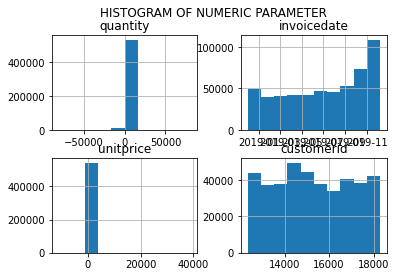

In [2]:
#df = pd.read_csv('ecommerce_dataset_us.csv', sep=None, engine='python')
df = pd.read_csv('ecommerce_dataset_us.csv', sep='\t')
df.columns = df.columns.str.lower() #lowercase column names
df['invoicedate'] = pd.to_datetime(df['invoicedate']) # adjust "invoicedate" to datetime data

print('DATAFRAME GENERAL INFORMATIONS:')
print(df.info())
print()

print('DATAFRAME FIRST AND LAST 5 ROWS:')
display(df.drop(df.index[5:-5]))
print()

print('OVERVIEW DATA DISTRIBUTION:')
display(df.describe(q, datetime_is_numeric=True))
print()

df.hist()
plt.suptitle('HISTOGRAM OF NUMERIC PARAMETER')
plt.show()

### COMMENT:

Dataset of ~550 000 records in about 1 year containing information:

+ `invoicedate`: from 2018-11-29 to 2019-12-07  

+ `invoiceno`: number of invoice  

+ `stockcode`: product id code  

+ `description`: product text description  

+ `quantity`: number of product unit in invoice majority about 1-30 . Have negative value and extreme outliers in both directions  

+ `unitprice`: price per unit of product majority about  £0.5-10. Have negative value and extreme outliers in both directions  

+ `cutomerid`: id of customer in charge of the invoice  

## CHECK MISSING, DUPLICATED, ABNORMAL DATA AND VARIABLE RELATIONSHIP

In [3]:
print('+ COLUMNS WITH MISSING DATA:', NaN_Columns(df))
print()
print('Proportion of missing data:')
missing = {}
for col in NaN_Columns(df):
    missing['nan_'+col] = df[col].isnull()
display(Subset_Distribution(df, cond=missing, unique=['invoiceno', 'stockcode']))

Breakline()

print('+ NUMBER OF DUPLICATED ROWS:', Subset_Size(df, df.duplicated()))
print()
dup_df = df[df.duplicated()]

print('Total revenue of duplicated rows is {:.2%} dataset total revenue'.format(sum(dup_df['unitprice']*dup_df['quantity'])/sum(df['unitprice']*df['quantity'])))
print()
print('Sample of duplicated rows:')
display(dup_df.sample(5))

Breakline()

print('+ PROPORTION OF ZERO/NEGATIVE QUANTITATIVE DATA:')

abnormal = {}
for col in ['quantity','unitprice']:
    abnormal['zero_'+col] = df[col]==0
    abnormal['negative_'+col] = df[col]<0

display(Subset_Distribution(df, cond=abnormal, unique=['invoiceno', 'stockcode','customerid']))

Breakline()

print('+ CHECK IF "INVOICENO" HAVE MULITPLE "CUSTOMERID":')
Check_Unique(df, 'invoiceno', 'customerid')
print()
# same invoiceno can have 2 invoicedate (different in minutes)

print('+ CHECK IF "STOCKCODE" HAVE MULITPLE "DESCRIPTION":')

multi_des = Check_Unique(df, 'stockcode', 'description')
print()
print('Example of multiple "description":')
display(df[df['stockcode']==multi_des.index[multi_des==multi_des.max()][0]].drop_duplicates('description'))

+ COLUMNS WITH MISSING DATA: ['description', 'customerid']

Proportion of missing data:


,nan_description,nan_customerid
total,1454 (0.27%),135080 (24.93%)
invoiceno,1454 (5.6%),3710 (14.3%)
stockcode,960 (23.6%),3810 (93.6%)



----------------------------------------------------------------------------------------------------

+ NUMBER OF DUPLICATED ROWS: 5268 (0.97%)

Total revenue of duplicated rows is 0.22% dataset total revenue

Sample of duplicated rows:


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
480570,577311,23581,JUMBO BAG PAISLEY PARK,1,2019-11-16 13:16:00,2.08,18225.0
293176,562584,47590A,BLUE HAPPY BIRTHDAY BUNTING,2,2019-08-05 14:16:00,5.45,13752.0
55362,540992,22078,RIBBON REEL LACE DESIGN,5,2019-01-10 16:57:00,2.10,17364.0
460092,575895,23294,SET OF 6 SNACK LOAF BAKING CASES,1,2019-11-09 14:50:00,0.83,17052.0
525895,580640,84992,72 SWEETHEART FAIRY CAKE CASES,1,2019-12-03 12:51:00,0.55,16910.0



----------------------------------------------------------------------------------------------------

+ PROPORTION OF ZERO/NEGATIVE QUANTITATIVE DATA:


,zero_quantity,negative_quantity,zero_unitprice,negative_unitprice
total,0 (0.00%),10624 (1.96%),2515 (0.46%),2 (0.00%)
invoiceno,0 (0.0%),5172 (20.0%),2155 (8.3%),2 (0.0%)
stockcode,0 (0.0%),2559 (62.9%),1419 (34.9%),1 (0.0%)
customerid,0 (0.0%),1589 (36.3%),31 (0.7%),0 (0.0%)



----------------------------------------------------------------------------------------------------

+ CHECK IF "INVOICENO" HAVE MULITPLE "CUSTOMERID":


,nunique_customerid,count
1,0,3710
0,1,22190



+ CHECK IF "STOCKCODE" HAVE MULITPLE "DESCRIPTION":


,nunique_description,count
2,0,112
0,1,3308
1,2,517
3,3,98
4,4,26
5,5,5
6,6,2
8,7,1
7,8,1



Example of multiple "description":


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
522,536409,20713,JUMBO BAG OWLS,1,2018-11-29 11:45:00,1.95,17908.0
136272,547957,20713,NaN,32,2019-03-26 15:16:00,0.00,NaN
263884,560039,20713,wrongly marked. 23343 in box,-3100,2019-07-12 14:27:00,0.00,NaN
380688,569831,20713,wrongly coded-23343,-800,2019-10-04 12:38:00,0.00,NaN
403534,571633,20713,found,100,2019-10-16 11:27:00,0.00,NaN
414145,572345,20713,Found,100,2019-10-22 10:53:00,0.00,NaN
415582,572547,20713,wrongly marked 23343,200,2019-10-22 17:01:00,0.00,NaN
420390,572890,20713,Marked as 23343,400,2019-10-24 14:14:00,0.00,NaN
422750,573114,20713,wrongly coded 23343,1000,2019-10-25 15:36:00,0.00,NaN


### COMMENT:

*Pool dataset containing mixed records without clear instructions was checked to find general rules. The checking process is simple but unstructured and will not be showed in detail to avoid distraction.*  

#### DETECTED GENERAL RULES: (should be confirmed with the provider of the dataset if possible)

+ `stockcode`: majority are combination of 5 digit number tailling with 0-2 letter. The tail letter (normally indicated different variant of the same product type) somtimes uppercase or lowercase causing multiple counted error. Non e-commerce products such as "amazon fee", "discount", etc. are coded differently (shorter code or all leter code).

+ `description`: majority are product name in uppercase. One product can have multiple description due to small variant in text recordings or non-order records. Non-order records are returned product or warehouse destruction of faulty products. Reason of these records can be stated in description in place of the normal product name and normally in lowercase such as "lost", "damaged", etc.

+ `quantity`: there is non zero quantity records but ~2% of negative quantity records indicating returned products or warehouse destruction of faulty products.  

+ `unitprice`: returned products have positive unitprice while warehouse product destruction have zero unitprice. Outliers unitprice (negative or extreme high) are caused by non-ecommerce product records.  

+ `invoiceno`: each invoiceno have only 1 customerid recorded. Some invoiceno have 2 invoicedate but only few minutes different in time. Invoiceno indicate either order or return/destroy process as there is non invoiceno with mixed positive and negative quantity records.  

+ `customerid`: Filling ~25% missing customerid records based on the same invoiceno resulting in 100% missing data can be filled with id "12346". id "12346" could be a general code for warehouse management or unknown customer records.  

NOTE: 
Dataset contains around 0.1% duplicated rows. However, these can be coincidence instead of real duplicated errors. These records (~0.2% total dataset revenue) are expected to have little affect the analysis result.

## DATA PREPROCESSING AND CALCULATION

In [4]:
print('+ LOWERCASE LETTER IN "STOCKCODE"')
print()
print('Number of original "stockcode":', df['stockcode'].nunique())

df['stockcode'] = df['stockcode'].apply(Simple_String, case='lower', remove=['space'])
print('Number of new "stockcode" - lowercase all letter:', df['stockcode'].nunique())

Breakline()

codelen = 5
print('+ IDENTIFIED LIST OF NON COMMERCE PRODUCT (only letter or less than', codelen, 'characters "stockcode")')
print()
specialcode = set(df[(df['stockcode'].str.isalpha()) | (df['stockcode'].str.len()<codelen)]['stockcode'].unique())
e_specialcode = {'dcgssboy','dcgssgirl','pads'}
x_specialcode = specialcode - e_specialcode

print(x_specialcode)
print()
print('Exception:', e_specialcode)
print()
display(df[df['stockcode'].isin(specialcode)].drop_duplicates('stockcode'))

+ LOWERCASE LETTER IN "STOCKCODE"

Number of original "stockcode": 4070
Number of new "stockcode" - lowercase all letter: 3958

----------------------------------------------------------------------------------------------------

+ IDENTIFIED LIST OF NON COMMERCE PRODUCT (only letter or less than 5 characters "stockcode")

{'dot', 'c2', 'amazonfee', 'cruk', 'b', 'bankcharges', 'm', 'post', 's', 'd'}

Exception: {'dcgssgirl', 'dcgssboy', 'pads'}



,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
45,536370,post,POSTAGE,3,2018-11-29 08:45:00,18.000,12583.0
141,C536379,d,Discount,-1,2018-11-29 09:41:00,27.500,14527.0
1423,536540,c2,CARRIAGE,1,2018-11-29 14:05:00,50.000,14911.0
1814,536544,dot,DOTCOM POSTAGE,1,2018-11-29 14:32:00,569.770,NaN
2239,536569,m,Manual,1,2018-11-29 15:35:00,1.250,16274.0
4406,536779,bankcharges,Bank Charges,1,2018-11-30 15:08:00,15.000,15823.0
14436,C537581,s,SAMPLES,-1,2018-12-05 12:03:00,12.950,NaN
14514,C537600,amazonfee,AMAZON FEE,-1,2018-12-05 12:41:00,1.000,NaN
84016,543358,dcgssboy,BOYS PARTY BAG,1,2019-02-05 14:04:00,3.290,NaN
84017,543358,dcgssgirl,GIRLS PARTY BAG,3,2019-02-05 14:04:00,3.290,NaN


__________ CREATE E-COMMERCE WORKING DATASET WITHOUT NON-COMMERCE PRODUCTS AND ZERO UNITPRICE __________

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536496 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoiceno    536496 non-null  object        
 1   stockcode    536496 non-null  object        
 2   description  536496 non-null  object        
 3   quantity     536496 non-null  int64         
 4   invoicedate  536496 non-null  datetime64[ns]
 5   unitprice    536496 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 28.7+ MB
None

+ PERCENTAGE OF ECOM_DF IN ORIGINAL DATASET:


,e-commerce records
total,536496 (99.00%)
invoiceno,23195 (89.6%)
stockcode,3818 (96.5%)



+ NUMBER OF UNIQUE CATEGORY DATA:
invoiceno    23195
stockcode     3818
dtype: int64

+ CALCULATE RECORD "REVENUE" AND "P_INVOICE" (revenue proportion of invoice):


,quantity,unitprice,revenue,p_invoice
count,536496.000000,536496.000000,536496.000000,5.364960e+05
mean,9.888435,3.285091,18.254367,4.323425e-02
std,215.954218,4.499904,367.938032,1.025426e-01
min,-80995.000000,0.001000,-168469.600000,4.895335e-07
1%,-1.000000,0.290000,-5.040000,3.134619e-04
5%,1.000000,0.420000,0.850000,8.271134e-04
25%,1.000000,1.250000,3.750000,5.113267e-03
50%,3.000000,2.080000,9.780000,1.693866e-02
75%,10.000000,4.130000,17.400000,4.199923e-02
95%,29.000000,9.950000,55.800000,1.445783e-01



+ ROUND UP "INVOICEDATE" TO "INVOICEMONTH":


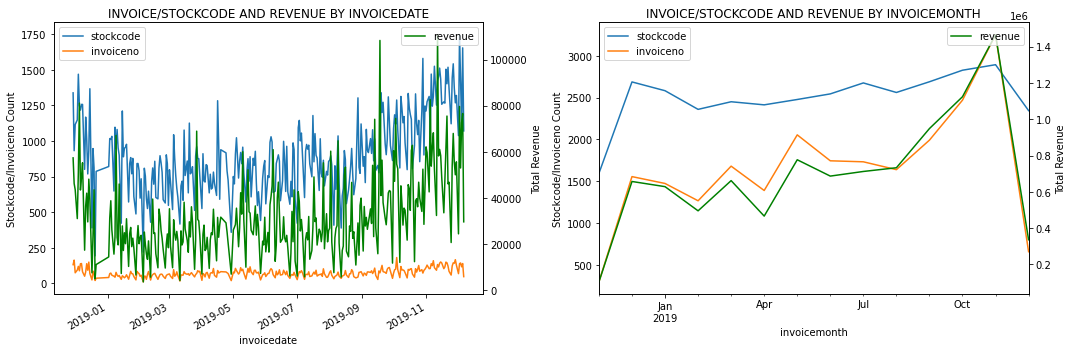

In [5]:
print('_'*10, 'CREATE E-COMMERCE WORKING DATASET WITHOUT NON-COMMERCE PRODUCTS AND ZERO UNITPRICE', '_'*10)
print()
ecom_df = df[(~df['stockcode'].isin(x_specialcode)) & (df['unitprice']>0)].drop('customerid', axis=1)
print(ecom_df.info())
print()

print('+ PERCENTAGE OF ECOM_DF IN ORIGINAL DATASET:')
display(Subset_Distribution(df, unique=['invoiceno', 'stockcode'],
        cond={'e-commerce records': (~df['stockcode'].isin(x_specialcode)) & (df['unitprice']>0)}))
print()

print('+ NUMBER OF UNIQUE CATEGORY DATA:')
cat_col = ['invoiceno', 'stockcode']
for col in cat_col:
    ecom_df[cat_col] = ecom_df[cat_col].astype('category')  # change to "category" datatype
print(ecom_df[cat_col].nunique())
print()

print('+ CALCULATE RECORD "REVENUE" AND "P_INVOICE" (revenue proportion of invoice):')
ecom_df['revenue'] = ecom_df['quantity'] * ecom_df['unitprice']         # calculate revenue
ecom_df['p_invoice'] = ecom_df.groupby('invoiceno')['revenue'].transform(lambda x: x/sum(x))
display(ecom_df.describe(q))
print()

print('+ ROUND UP "INVOICEDATE" TO "INVOICEMONTH":')
ecom_df['invoicedate'] = ecom_df['invoicedate'].astype('datetime64[D]') # round up datetime data
ecom_df['invoicemonth'] = ecom_df['invoicedate'].astype('datetime64[M]')

fig, ax = plt.subplots(ncols=2, figsize=(15,5))
i=0
for col in ['invoicedate', 'invoicemonth']:
    ecom_df.groupby(col)[['stockcode', 'invoiceno']].nunique().plot.line(ax=ax[i])
    ax[i].set(ylabel='Stockcode/Invoiceno Count')
    ax2 = ax[i].twinx()
    ecom_df.groupby(col)['revenue'].sum().plot.line(ax=ax2, color='green', label='revenue')
    ax2.legend(loc='upper right')
    ax2.set(title='INVOICE/STOCKCODE AND REVENUE BY '+col.upper(), ylabel='Total Revenue')
    i+=1
plt.tight_layout()
plt.show()

### COMMENT:  

Create new ecom dataset (99% original dataset) without:  

+ 10 detected non-ecommerce product (postage, discount, carriage, dotcom postage, manual, bank charges, samples, amazon fee, adjust bad debt, cruk commission)  

+ unnecessary customerid columns  

+ not real transaction records with zero unitprice  

THE NEW DATASET CONTAINS REAL TRANSACTIONS RECORDS OF TOTAL 3818 E-COMMERCE PRODUCTS.  
While the number of invoice and revenue increase steadily through time, the number of active products are more stable around 2500 products a month.


# PART_2> PRODUCT DESCRIPTION ANALYSIS <a id="part_2"></a>

In [6]:
'''
APPROACH EXPLAINATION:

To study product range, a dataframe of product `stockcode` as index are created. Each product will have most common `description` and `keyword` as set of importance words in `description`.

Product description are short phrase where most words are importance so simple string split are used instead of pos-tag (higher error with short phrase) and word blob (inconsistence results of word order).

Number, symbol, short word (<3 characters) and common "english" stop words are removed and chosen words are lemmatized.
'''

print('+ FIND MOST COMMON DESCRIPTION AND EXTRACT KEYWORD FOR EACH STOCKCODE')
print()

keywordlen = 3
stop_words = stopwords.words('english')

# filter all lowercase descriptions
ecom2 = ecom_df[~ecom_df['description'].str.islower()][['stockcode', 'description']]

# lowercase remaning "good" descriptions
ecom2['description'] = ecom2['description'].apply(Simple_String, case='lower', remove=['extra_space', 'symbol', 'number']) 

# find most common description of each stockcode
description = ecom2.groupby('stockcode')['description'].agg(lambda x: x.value_counts().index[0])

# extract keyword of most common description
keyword = description.apply(Find_Keyword, n=keywordlen, lem=True, filter=stop_words).rename('keyword')

print('Numer of "stockcode" with identified "keyword":', Subset_Size(keyword, keyword!=set()))
print()

print('Example:')
product = pd.concat([description, keyword], axis=1)
display(product.sample(5))
print()

print('+ NUMBER OF IDENTIFIED KEYWORDS FOR EACH PRODUCT:')
display(keyword.apply(lambda x: len(x)).value_counts().sort_index().reset_index().rename(columns={'index':'product_n_keywords', 'keyword': 'count'}))

+ FIND MOST COMMON DESCRIPTION AND EXTRACT KEYWORD FOR EACH STOCKCODE

Numer of "stockcode" with identified "keyword": 3818 (100.00%)

Example:


,description,keyword
stockcode,,
23513,embroidered ribbon reel susie,"{embroidered, susie, ribbon, reel}"
22141,christmas craft tree top angel,"{tree, angel, craft, christmas, top}"
22048,birthday banquet gift wrap,"{gift, birthday, banquet, wrap}"
21694,small regal silver candlepot,"{small, candlepot, regal, silver}"
70007,hi tec alpine hand warmer,"{alpine, warmer, tec, hand}"



+ NUMBER OF IDENTIFIED KEYWORDS FOR EACH PRODUCT:


,product_n_keywords,count
0,1,1
1,2,82
2,3,858
3,4,1917
4,5,883
5,6,77


### COMMENT:

+ Each product are indentified with maximum 5 keywords (majority 2-4 keywords).

+ Nearly 2000 keywords are decteted but 50% keywords appeared in only 1-2 products.

In [7]:
'''
APPROACH EXPLAINATION:

Keyword sets of all products are pulled together and each word occurrence is counted.

These total WORD_COUNT will be used a REFERENCE base for later keyword analysis of product groups.
For example, some common words will always have top word count but the proportion of these words could be smaller in some specific groups compare to the REFERENCE. 

WORD_CORR calculate the correlation coefficicent of word pair (word often appear together will have higher score). Alternatively, word pair co-occurrence can be used. With co-occurrence, popular word often have higher count and appear on top list while with correlation unique pair will have higher score.
'''

sig_threshold = 30

word_count, word_corr = Keyword_Study(keyword, threshold=sig_threshold)

print('+ REPEATED KEYWORD DISTRIBUTION:')
display(word_count.describe(q))
print()

print('+ TOP POPULAR KEYWORDS')
print(', '.join(word_count.index[:20]))
print()

print('+ TOP CORRELATED WORD PAIR (only keywords identified in at least {} products)'.format(sig_threshold))
display(word_corr.head(20))


+ REPEATED KEYWORD DISTRIBUTION:


count    1843.000000
mean        8.293001
std        21.479503
min         1.000000
1%          1.000000
5%          1.000000
25%         1.000000
50%         2.000000
75%         6.000000
95%        34.900000
99%       104.000000
max       359.000000
dtype: float64


+ TOP POPULAR KEYWORDS
set, pink, heart, blue, vintage, red, bag, glass, box, christmas, flower, candle, card, white, design, holder, small, metal, decoration, rose

+ TOP CORRELATED WORD PAIR (only keywords identified in at least 30 products)


pair
cushion - cover      0.727287
tlight - holder      0.706010
girl - dolly         0.690067
metal - sign         0.659394
key - ring           0.606938
earring - drop       0.592461
letter - key         0.588643
frame - photo        0.564744
letter - ring        0.517961
art - wall           0.503553
fairy - cake         0.407930
cake - stand         0.383393
christmas - tree     0.370132
red - retrospot      0.366704
cake - case          0.357678
french - sign        0.328405
clock - wall         0.286878
egg - easter         0.275900
metal - french       0.260805
colour - assorted    0.233033
Name: corr, dtype: float64

### COMMENT:

According to popular keywords, majority of product are small decoration especially in classic style for personal use or event purpose.

In [8]:
print('+ GROUP PRODUCTS WITH AT LEAST 3 MATCHING KEYWORDS')
print()

# TIME CONSUMING STEP!!! GENERATED DATAFRAME SHOULD BE SAVED FOR LATER USED

# product['groupcode'] = product.index
# for p1 in product.index:
#     for p2 in product.index:
#          if len(product.loc[p1,'keyword'].intersection(product.loc[p2,'keyword']))>=3:
#             product.loc[p2,'groupcode'] = product.loc[p1,'groupcode']
                        
#product.to_csv('ecom_project_product.csv')
product = pd.read_csv('ecom_project_product.csv', index_col='stockcode')
product['keyword'] = product['keyword'].apply(lambda x: set(Simple_String(x, remove=['symbol']).split()))

print('Number of identified groups:', product['groupcode'].nunique())
print()

group_count = product['groupcode'].value_counts()
print('Number of products without group:', Subset_Size(product, product['groupcode'].isin(group_count.index[group_count==1])))
print()

print('Sample of products in the same group:')
display(product[product['groupcode']==group_count.index[0]].sample(5))
print()

print('+ DISTRIBUTION OF GROUP SIZE:')
display(group_count.describe(q))
print()

print('+ TOP 10 GROUP IN SIZE:')
display(product[product['groupcode'].isin(group_count.index[:10])].drop_duplicates('groupcode'))

+ GROUP PRODUCTS WITH AT LEAST 3 MATCHING KEYWORDS

Number of identified groups: 2081

Number of products without group: 1575 (41.25%)

Sample of products in the same group:


,description,keyword,groupcode
stockcode,,,
84978,hanging heart jar tlight holder,"{heart, hanging, tlight, holder, jar}",21816
71459,hanging jam jar tlight holder,"{hanging, tlight, holder, jam, jar}",21816
22216,tlight holder white lace,"{lace, white, holder, tlight}",21816
22178,victorian glass hanging tlight,"{victorian, hanging, glass, tlight}",21816
85118,heart tlight holder,"{heart, tlight, holder}",21816



+ DISTRIBUTION OF GROUP SIZE:


count    2081.000000
mean        1.834695
std         2.930373
min         1.000000
1%          1.000000
5%          1.000000
25%         1.000000
50%         1.000000
75%         1.000000
95%         5.000000
99%        14.000000
max        60.000000
Name: groupcode, dtype: float64


+ TOP 10 GROUP IN SIZE:


,description,keyword,groupcode
stockcode,,,
16156s,wrap pink fairy cakes,"{cake, wrap, pink, fairy}",21621
18097c,white tall porcelain tlight holder,"{tlight, holder, tall, porcelain, white}",21816
20676,red retrospot bowl,"{red, retrospot, bowl}",20676
20718,red retrospot shopper bag,"{retrospot, shopper, red, bag}",23545
21009,etched glass star tree decoration,"{tree, decoration, etched, glass, star}",21147
21171,bathroom metal sign,"{bathroom, metal, sign}",22670
21479,white skull hot water bottle,"{hot, bottle, white, water, skull}",21479
22296,heart ivory trellis large,"{ivory, trellis, heart, large}",22469
35646,vintage bead pink evening bag,"{vintage, bead, bag, evening, pink}",90114


### COMMENT:

More than 50% products are detected as style variant of other product. Decoration products have the most detected variant.

# PART_3> PRODUCT MARKET VALUE ANALYSIS <a id="part_3"></a>

## PRODUCT METRICS

### COMMENT:

+ `recency`: 50% of products were active in the last 2 days (75% in the last month). There are small amount of outdated products having return-records but not order-records. These outdated products are removed. 

+ products `frequency` and `monetary` are strongly correlated. Majority products was ordered ~70 times and created ~£700 revenue within the year. However, there are some "good" products bringing above £25000 revenue.

+ 99% product are under £20 per unit while highest "unitprice" product is ~£150

+ Average product `return_rate` is around 2% but median at 0.3%.

+ CALCULATE PRODUCT METRICS:

. Today: 2019-12-07 00:00:00
. "recency": number of days from last order
. "frequency": number of order invoice
. "unitprice": average unitprice of order invoice
. "weight": average of invoice revenue proportion
. "monetary": total revenue
. "return_frequency": number of return invoice
. "return_rate" = "return_frequency" / "frequency"



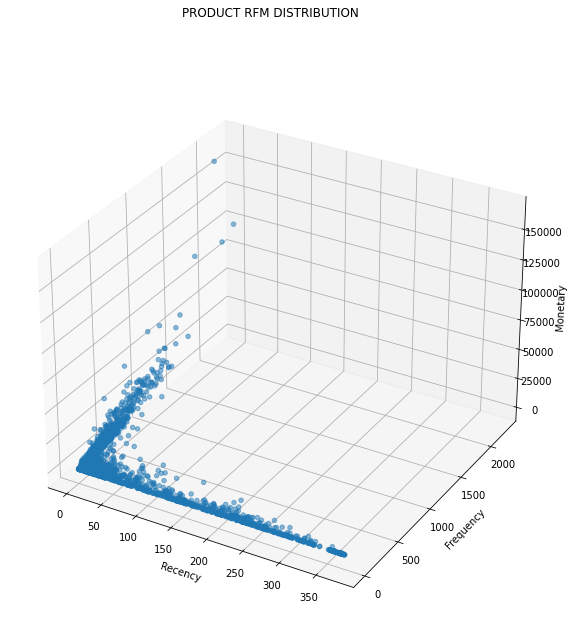

+ NUMBER OF OUTDATED PRODUCTS: 14 (0.37%)

Sample of outdated products:


,description,keyword,groupcode,recency,frequency,weight,unitprice,monetary,return_frequency,return_rate
stockcode,,,,,,,,,,
21412,vintage gold tinsel reel,"{tinsel, gold, vintage, reel}",21268,NaN,0,NaN,NaN,-2.52,1,inf
79320,flamingo lights,"{light, flamingo}",79320,NaN,0,NaN,NaN,-4.95,1,inf
37503,tea time cake stand in gift box,"{cake, tea, time, stand, gift, box}",37500,NaN,0,NaN,NaN,-10.75,1,inf



+ DISTRIBUTION OF PRODUCTS METRICS (without outdated products):


,recency,frequency,weight,unitprice,monetary,return_frequency,return_rate
count,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000
mean,44.711882,135.993954,0.035952,3.845591,2574.554459,2.265510,0.022128
std,89.169564,195.491014,0.055012,7.156660,6364.844760,5.803103,0.098873
min,0.000000,1.000000,0.000002,0.001000,-45.700000,0.000000,0.000000
1%,0.000000,1.000000,0.001087,0.240105,2.100000,0.000000,0.000000
5%,0.000000,2.000000,0.003792,0.436613,11.550000,0.000000,0.000000
25%,0.000000,18.000000,0.013799,1.250000,139.252500,0.000000,0.000000
50%,2.000000,69.000000,0.025590,2.355985,707.605000,1.000000,0.002950
75%,28.000000,171.000000,0.042545,4.302416,2248.045000,2.000000,0.018272
95%,262.850000,494.700000,0.086656,10.397756,11161.708000,11.000000,0.083333


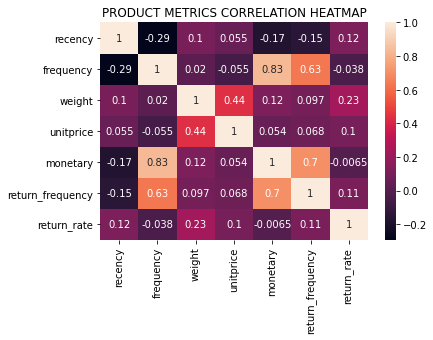

In [9]:
print('+ CALCULATE PRODUCT METRICS:')
print()

today = ecom_df['invoicedate'].max() # today is set as dataset last day instead of actual current date as in real life project 

print('. Today:', today)
print('. "recency": number of days from last order')
print('. "frequency": number of order invoice')
print('. "unitprice": average unitprice of order invoice')
print('. "weight": average of invoice revenue proportion')
print('. "monetary": total revenue')
print('. "return_frequency": number of return invoice')
print('. "return_rate" = "return_frequency" / "frequency"')
print()

RFW = ecom_df[ecom_df['quantity']>0].groupby('stockcode').agg({'invoicedate': lambda x: today - x.max(), 'invoiceno': 'nunique', 'p_invoice': 'mean', 'unitprice': 'mean'}).rename(columns={'invoicedate': 'recency', 'invoiceno': 'frequency', 'p_invoice': 'weight'})

M = ecom_df.groupby('stockcode')['revenue'].sum().rename('monetary')

returnF = ecom_df[ecom_df['quantity']<0].groupby('stockcode')['invoiceno'].nunique().rename('return_frequency')

product = product.join([RFW, M, returnF]) # join to product description dataframe
product['recency'] = product['recency'].dt.days # outdated product have NaN "recency"
product['return_rate'] = product['return_frequency']/product['frequency'] # outdated product have inf "return_rate" 

# 3D scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection = '3d')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.scatter(product['recency'], product['frequency'], product['monetary'], alpha=0.5)
plt.suptitle('PRODUCT RFM DISTRIBUTION')
plt.show()

print('+ NUMBER OF OUTDATED PRODUCTS:', Subset_Size(product, product['recency'].isna()))
print()
print('Sample of outdated products:')
display(product[product['recency'].isna()].sample(3))
print()

print('+ DISTRIBUTION OF PRODUCTS METRICS (without outdated products):')
product.dropna(subset=['recency'], inplace=True) # drop outdated products
word_count = Keyword_Study(product['keyword'])[0] # recalculate word_count reference
display(product.describe(q))
print()

# plot heatmap
sns.heatmap(product.corr(), annot=True).set(title='PRODUCT METRICS CORRELATION HEATMAP')
plt.show()

## PRODUCT KMEANS CLUSTERING

+ ESTIMATE NUMBER OF CLUSTERS:


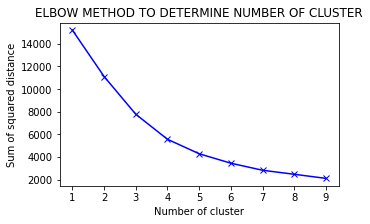


KMEANS CLUSTERING PRODUCT TO 4 GROUPS


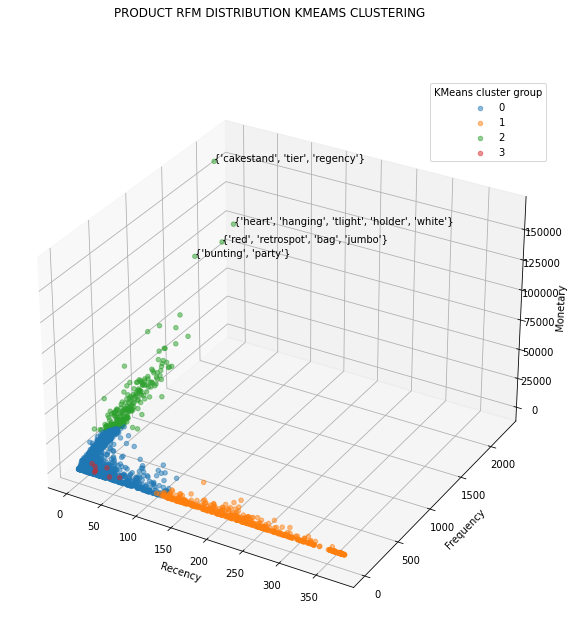


+ PRODUCT "KMGROUP" AVERAGE METRICS:


,recency,frequency,weight,unitprice,monetary,return_frequency,return_rate
KMgroup,,,,,,,
0,10.739015,115.696405,0.031966,3.391872,1691.253107,1.794274,0.017508
1,239.943860,16.724561,0.046133,4.275237,248.616404,0.421053,0.046561
2,0.881818,727.590909,0.050514,4.055571,20659.668182,13.472727,0.018023
3,86.200000,16.600000,0.332585,111.033325,2624.248000,2.400000,0.107732



+ PRODUCT "KMGROUP" KEYWORD ANALYSIS:


,groupsize,top_count_not_in_reference,common_pair,significant_lower_proportion,significant_higher_proportion
0,3004,[],"[tlight - holder, girl - dolly, cushion - cover, sign - metal, key - ring, key - letter, drop - earring, ring - letter, art - wall, french - sign, tree - christmas, retrospot - red, french - metal, wall - clock, cup - egg, drawer - ceramic, bird - love, earring - crystal, french - blue, bag - ch...",[],[]
1,570,[],[],[],"[glass, flower, pink, bead]"
2,220,"[jumbo, lunch]",[],"[necklace, garden, earring, mug, bracelet, candle, decoration]","[bag, retrospot, tin, design, cake, sign, tlight, red, box]"
3,10,"[cabinet, kitchen, drawer, decorative, seventeen, shelving, regency]",[],[],"[love, gift, vintage]"


In [10]:
X = StandardScaler().fit_transform(product[['recency', 'frequency','monetary','unitprice']])

print('+ ESTIMATE NUMBER OF CLUSTERS:')
Elbow_Method(X)
print()

product_cluster = 4
print('KMEANS CLUSTERING PRODUCT TO {} GROUPS'.format(product_cluster))
product['KMgroup'] = KMeans(product_cluster, random_state=seed).fit_predict(X)

# 3D SCATTER PLOT
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection = '3d')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

for group in range(product_cluster):
    sample = product[product['KMgroup']==group]
    ax.scatter(sample['recency'], sample['frequency'], sample['monetary'], alpha=0.5, label=group)

ax.legend(title='KMeans cluster group')

# plot text label
top_product = product.sort_values('monetary', ascending=False).head(4) # label top product
for i in top_product.index: 
    ax.text(top_product.loc[i,'recency'],top_product.loc[i,'frequency'],top_product.loc[i,'monetary'],top_product.loc[i,'keyword']) 

plt.suptitle('PRODUCT RFM DISTRIBUTION KMEAMS CLUSTERING')
plt.show()
print()

print('+ PRODUCT "KMGROUP" AVERAGE METRICS:')
display(product.groupby('KMgroup').mean())
print()

print('+ PRODUCT "KMGROUP" KEYWORD ANALYSIS:')
table1 = {}
for group in range(product_cluster):
    # Ztest proportion comparision compare only common words (above 50 counts in reference)
    table1[group] = Keyword_Compare(product[product['KMgroup']==group]['keyword'], reference=word_count[word_count>50], reference_size=len(product))
table1 = pd.DataFrame.from_dict(table1, orient='index')
display(table1)

### COMMENT:  

Products are categorized into 4 groups using KMeans clustering methods:
+ **0 - Average Products**: ~3/4 of product dataset with average metrics and no significant characteristics.

+ **1 - Bad Products**: ~600 products on the bad side of RFM frame.There is significant higher proportion of [glass, flower, pink, bead] keywords and lower proprotion of [retrospot, card] keywords in these product description. These products also have higher `return_rate` 

+ **2 - Good Products**: ~200 products on high end of RFM frame. These products are more likely [bag, retrospot, tin, design, cake, sign, tlight, red, jumbo, lunch, box] and less likely [necklace, garden, earring, mug, bracelet, candle, decoration, flower]  

+ **3 - Expensive Products**: small amount of outlier `unit_price` products are mostly furniture. This auto generated cluster is too small for metrics comparision.

## OTHER PRODUCT GROUPS

In [11]:
top_q = 0.8 # to choose top quantile of monetary and frequency
recency_threshold = 10 # to choose current active products
frequency_threshold = 30 # to choose high return_rate products as return_rate is not stable when frequency is too small
return_rate_threshold = 0.05 # to choose high return_rate products
weight_threshold = 0.15 # to choose high weight products
unitprice_threshold = 20 # to choose expensive products

product_group_description = {
            'best value'    : 'top {:.0%} "monetary"'.format(1-top_q),
            'popular'       : 'top {:.0%} "frequency"'.format(1-top_q),
            'current product': '"recency" less than {} days'.format(recency_threshold),
            'new promising': 'current products with below average "frequency" and above average "monetary"',
            'high return rate': '"return rate" above {:.0%} (only product with "frequency" above {})'.format(return_rate_threshold, frequency_threshold),
            'high weight': 'average of invoice revenue proportion above {:.0%}'.format(weight_threshold),
            'expensive'     : '"unitprice" above {}'.format(unitprice_threshold)
            }

product_group = {
            'best value'    : product['monetary']>product['monetary'].quantile(top_q),
            'popular'       : product['frequency']>product['frequency'].quantile(top_q),

            'current product': product['recency']<recency_threshold,
            'new promising': (product['recency']<recency_threshold) & (product['frequency']<product['frequency'].mean()) & (product['monetary']>product['monetary'].mean()),
            'high return rate': (product['return_rate']>return_rate_threshold) & (product['frequency']>frequency_threshold),
            'high weight': product['weight']>weight_threshold,
            'expensive'     : product['unitprice']>unitprice_threshold,
            }

for group in product_group_description.keys():
    print('. "{}": {}'.format(group, product_group_description[group]))
    print()
print()

table2 = {}
for group in product_group.keys():
    table2[group] = Keyword_Compare(product[product_group[group]]['keyword'], reference=word_count[word_count>50], reference_size=len(product))
table2 = pd.DataFrame.from_dict(table2, orient='index')
display(table2)

. "best value": top 20% "monetary"

. "popular": top 20% "frequency"

. "current product": "recency" less than 10 days

. "new promising": current products with below average "frequency" and above average "monetary"

. "high return rate": "return rate" above 5% (only product with "frequency" above 30)

. "high weight": average of invoice revenue proportion above 15%

. "expensive": "unitprice" above 20




,groupsize,top_count_not_in_reference,common_pair,significant_lower_proportion,significant_higher_proportion
best value,761,[],"[retrospot - red, vintage - christmas]","[necklace, earring, bracelet, crystal, bead, tree, flower, candle]","[retrospot, tin, cake, bag, design, sign]"
popular,758,[],[red - retrospot],"[necklace, earring, bracelet, bead, crystal, flower, cover, art]","[retrospot, tin, sign, bag, design]"
current product,2476,[],"[girl - dolly, sign - metal, tlight - holder, ring - key, wall - art, key - letter, letter - ring, cover - cushion, red - retrospot, tree - christmas, tlight - hanging, sign - blue]",[],[]
new promising,61,"[frame, landmark, doormat, baby]",[],[],"[wall, art, gift, love, bowl]"
high return rate,202,[jar],[],"[necklace, paper, card, metal]","[cake, tin, large, glass, retrospot, box, hanging]"
high weight,66,"[cabinet, table, chair, stool]",[],[],[]
expensive,41,"[cabinet, voucher, dotcomgiftshop, drawer, chair, chandelier, kitchen]",[],[],"[gift, vintage]"


### COMMENT:

+ Jewelry as [necklace, earring, bracelet, crystal, bead] or [flower] have lower proportion in high `frequency`-`monetary` products while [retrospot - red, tin, cake, bag, design, sign] have higher chance to be good value products. This is consistent with previous result.

+ [blue, metal, necklace, bag, flower, card] are less likely to be returned. On the other hand, higher proportion of keywords [glass, jar] in high `return_rate` products could suggest posibility of damaged delivered.

+ Currently, there are a wide variety of [dolly girl, metal sign, tlight holder , key ring letter, wall art] products. However, [wall art, gift, bowl, landmark frame, doormat] could be new trending products.

+ Expensive product are [vintage] furniture [cabinet, drawer, wooden, kitchen] or [dotcomgiftshop, voucher, gift].

# PART_4> PRODUCT BUNDLE ANALYSIS OF RECENT INVOICES <a id="part_4"></a>

+ "revenue": total revenue
+ "variety": number of products
+ "highest_proportion": highest product revenue proportion in invoice


,revenue,variety,highest_proportion
count,2910.000000,2910.000000,2910.000000
mean,581.691986,30.629210,0.273839
std,3379.866941,67.586907,0.260345
min,1.650000,1.000000,0.020245
1%,6.240900,1.000000,0.032265
5%,33.504000,1.000000,0.052381
25%,154.602500,7.000000,0.099226
50%,293.055000,15.000000,0.176252
75%,450.070000,31.000000,0.334262
95%,1576.733000,86.550000,1.000000


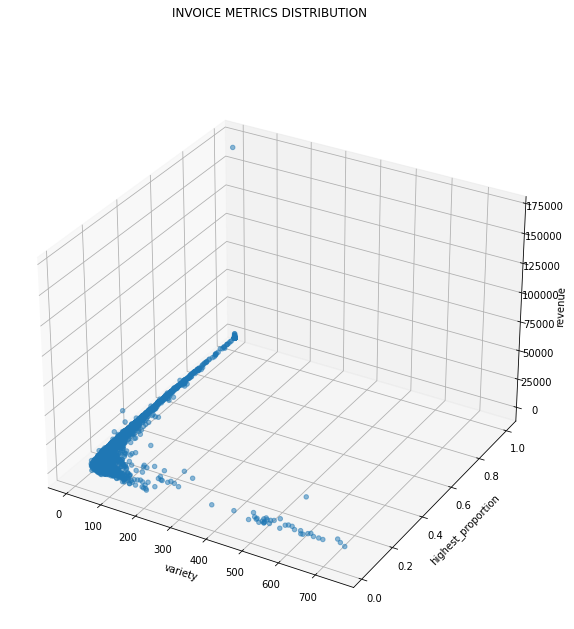

In [12]:
'''
APPROACH EXPLAINATION:

Calculation of product correlation is a memory intensive process especially when the number of invoice and products are high.

Recent 1 month records covering most promising products (~75% total products) would be enough for product bundle analysis.
'''
# CREATE A SLICE DATAFRAME COPY
#ecom_df[(ecom_df['quantity']>0) & (ecom_df['invoicedate']>=(today-np.timedelta64(30,'D')))].reindex().to_csv('ecom_project_invoice.csv', index=False)
ecom_df_one_month = pd.read_csv('ecom_project_invoice.csv')
# CALCULATION
invoice = ecom_df_one_month.groupby('invoiceno').agg({'revenue':'sum', 'stockcode': ['count', lambda x: set([i for i in x])], 'p_invoice': 'max'})
invoice.columns = ['revenue', 'variety', 'product', 'highest_proportion']

print('+ "revenue": total revenue')
print('+ "variety": number of products')
print('+ "highest_proportion": highest product revenue proportion in invoice')
display(invoice.describe(q))
print()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection = '3d')

ax.set_xlabel('variety')
ax.set_ylabel('highest_proportion')
ax.set_zlabel('revenue')

ax.scatter(invoice['variety'], invoice['highest_proportion'], invoice['revenue'], alpha=0.5)
plt.suptitle('INVOICE METRICS DISTRIBUTION')
plt.show()


### COMMENT: 

Majority of ~3000 recent invoices contain ~7-30 products and cost ~£150-450.  

However, there are extreme invoice outliers in size.   

For better invoice clustering, a threshold of under 200 products and under £2000 revenue is set to remove ~5% outliers.

+ ESTIMATE NUMBER OF CLUSTERS:


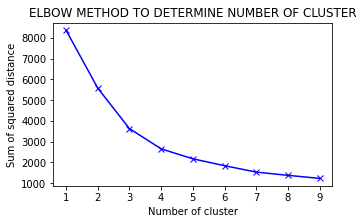


KMEANS CLUSTERING INVOICE TO 4 GROUPS


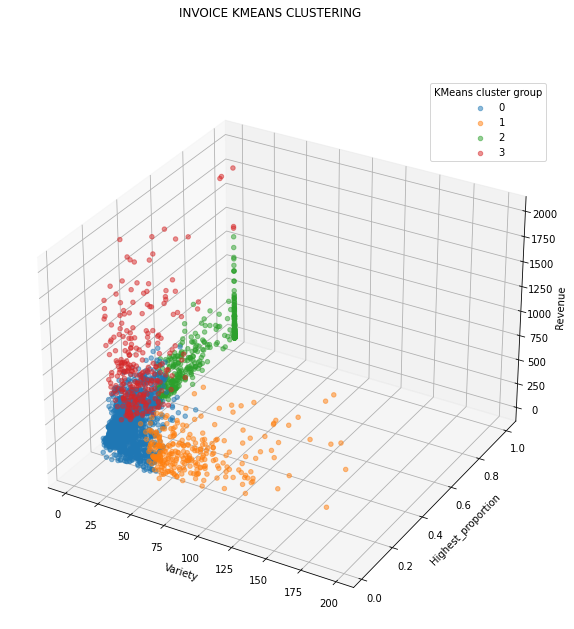


+ INVOICE "KMGROUP" AVERAGE METRICS:


,revenue,variety,highest_proportion
KMgroup,,,
0,269.980269,17.205387,0.195917
1,442.823321,81.145985,0.075019
2,160.846255,2.588745,0.779364
3,1009.568155,31.295203,0.169990



+ OVERVIEW COMMON PRODUCT OF INVOICE "KMGROUP":


,groupsize,top_count_not_in_reference,significant_lower_proportion,significant_higher_proportion
0,1782,[],[],[]
1,274,"[hand warmer red love heart, rex cashcarry jumbo shopper, gardeners kneeling pad cup of tea]",[],"[gardeners kneeling pad keep calm, popcorn holder, lunch bag paisley park, wooden star christmas scandinavian, white hanging heart tlight holder, hand warmer owl design, jumbo bag s christmas, hot water bottle keep calm, paper chain kit vintage christmas, paper chain kit s christmas, jumbo bag p..."
2,462,"[regency cakestand tier, baking set piece retrospot, lunch bag red vintage doily, bicycle puncture repair kit]","[hand warmer owl design, gardeners kneeling pad keep calm, hot water bottle keep calm, lunch bag paisley park, chocolate hot water bottle, jumbo bag paisley park, jumbo bag red retrospot, paper chain kit vintage christmas]",[]
3,271,"[hot water bottle tea and sympathy, regency cakestand tier, set of regency cake tins]",[],"[jumbo bag red retrospot, chocolate hot water bottle, assorted colour bird ornament]"


In [13]:
'''
APPROACH EXPLAINATION:

Similar to previous keyword analysis, product "stockcode" is considered as keyword and check for significant higher/lower proportion in different invoice group. 
'''

normal_invoice = invoice[(invoice['variety']<200) & (invoice['revenue']<2000)].reindex()

product_count, product_corr = Keyword_Study(normal_invoice['product'], threshold=50) #generate invoice product_count reference

X2 = StandardScaler().fit_transform(normal_invoice[['variety', 'revenue','highest_proportion']])

print('+ ESTIMATE NUMBER OF CLUSTERS:')
Elbow_Method(X2)
print()

invoice_cluster = 4
print('KMEANS CLUSTERING INVOICE TO {} GROUPS'.format(invoice_cluster))
normal_invoice['KMgroup'] = KMeans(invoice_cluster, random_state=seed).fit_predict(X2)

# 3D SCATTER PLOT
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection = '3d')

ax.set_xlabel('Variety')
ax.set_ylabel('Highest_proportion')
ax.set_zlabel('Revenue')

for group in range(product_cluster):
    sample = normal_invoice[normal_invoice['KMgroup']==group]
    ax.scatter(sample['variety'], sample['highest_proportion'], sample['revenue'], alpha=0.5, label=group)

ax.legend(title='KMeans cluster group')

plt.suptitle('INVOICE KMEANS CLUSTERING')
plt.show()
print()

print('+ INVOICE "KMGROUP" AVERAGE METRICS:')
display(normal_invoice.groupby('KMgroup').mean())
print()

print('+ OVERVIEW COMMON PRODUCT OF INVOICE "KMGROUP":')
table3 = {}
table4 = {}
for group in range(invoice_cluster):
    # Ztest product "stockcode" proportion comparision
    table3[group] = Keyword_Compare(normal_invoice[normal_invoice['KMgroup']==group]['product'],  reference=product_count[product_count>180], reference_size=len(normal_invoice))

table3 = pd.DataFrame.from_dict(table3, orient='index').drop('common_pair', axis=1)
for col in table3: # change product "stockcode" to "description" for showing
    if col!= 'groupsize':
        table3[col] = table3[col].apply(lambda x: product.loc[x]['description'].tolist())
display(table3)

### COMMENT:

Invoice are categorized into 4 groups using KMeans clustering methods:

+ **0 - Main Purchase**: ~15% of invoice containing one product with very high proportion of the invoice revenue (average ~75%). Product often appear in this group are [regency cakestand tier, lunch bag red vintage doily, bicycle puncture repair kit, antique silver tlight glass]. Similar products of the "variety purchase" group also less likely appear in this group. 

+ **1 - Big Purchase**: ~10% of invoice are very high in revenue. Some noticing products are [hot water bottle, regency cakestand tier, regency cake tins, jumbo bag, hot water bottle, bird ornament]  

+ **2 - Average Purchase**: ~2/3 of normal recent invoice dataset with average metrics  

+ **3 - Variety Purchase**: ~10% of invoice are very high in variety (average ~80 products). These invoice more likely contain [garden kneeling pad, hot water bottle, hand warmer, jumbo bag, christmas decoration, etc.] products

In [14]:
'''
APPROACH EXPLAINATION:

Similar to calculation of keyword correlation, product correlation are calculate to see which products often appear in the same invoice.

The product pairs are also checked to see if they are in the same big group (at least 3 matching keywords)
'''
product_corr = product_corr.reset_index()
product_corr['paircode'] = product_corr['pair'].apply(lambda x: x.split(' - '))
product_corr['same_group'] = product_corr['paircode'].apply(lambda x: 1 if product.loc[x[0], 'groupcode'] == product.loc[x[1],'groupcode'] else 0)
product_corr['description'] = product_corr['paircode'].apply(lambda x: [product.loc[i,'description'] for i in x])
product_corr.drop(['pair'], axis=1, inplace=True)

print('+ TOP SIMILAR PRODUCT OFTEN BOUGHT TOGETHER')
display(product_corr[product_corr['same_group']==1].head(15))

Breakline()

print('+ TOP LESS SIMILAR PRODUCT OFTEN BOUGHT TOGETHER')
display(product_corr[product_corr['same_group']==0].head(15))

+ TOP SIMILAR PRODUCT OFTEN BOUGHT TOGETHER


,corr,paircode,same_group,description
0,0.747857,"[23266, 23265]",1,"[set of wooden stocking decoration, set of wooden tree decorations]"
1,0.737785,"[22577, 22578]",1,"[wooden heart christmas scandinavian, wooden star christmas scandinavian]"
2,0.727763,"[22727, 22726]",1,"[alarm clock bakelike red, alarm clock bakelike green]"
3,0.722510,"[22697, 22698]",1,"[green regency teacup and saucer, pink regency teacup and saucer]"
4,0.699399,"[22574, 22573]",1,"[heart wooden christmas decoration, star wooden christmas decoration]"
6,0.693677,"[22753, 22754]",1,"[small yellow babushka notebook, small red babushka notebook]"
7,0.656774,"[23264, 23265]",1,"[set of wooden sleigh decorations, set of wooden tree decorations]"
8,0.639433,"[22697, 22699]",1,"[green regency teacup and saucer, roses regency teacup and saucer]"
9,0.621976,"[23266, 23264]",1,"[set of wooden stocking decoration, set of wooden sleigh decorations]"
10,0.615661,"[22699, 22698]",1,"[roses regency teacup and saucer, pink regency teacup and saucer]"



----------------------------------------------------------------------------------------------------

+ TOP LESS SIMILAR PRODUCT OFTEN BOUGHT TOGETHER


,corr,paircode,same_group,description
5,0.695741,"[23498, 23552]",0,"[classic bicycle clips, bicycle puncture repair kit]"
11,0.607739,"[21819, 21818]",0,"[glitter christmas star, glitter heart decoration]"
12,0.601704,"[22629, 22630]",0,"[spaceboy lunch box, dolly girl lunch box]"
15,0.585775,"[20724, 22356]",0,"[red retrospot charlotte bag, charlotte bag pink polkadot]"
18,0.568202,"[22273, 22274]",0,"[feltcraft doll molly, feltcraft doll emily]"
24,0.543091,"[22633, 23439]",0,"[hand warmer union jack, hand warmer red love heart]"
27,0.528731,"[21619, 21620]",0,"[vanilla botanical candles, set of rose botanical candles]"
28,0.525426,"[22555, 22556]",0,"[plasters in tin strongman, plasters in tin circus parade]"
31,0.520061,"[22816, 22818]",0,"[card motorbike santa, card christmas village]"
34,0.505932,"[22356, 23204]",0,"[charlotte bag pink polkadot, charlotte bag apples design]"


### COMMENT:

Most of highly correlated products are different style variants of the same product.  

A noticing supplement purchase pair is [classic bicycle clips, bicycle puncture repair kit]

# PART_5> RETURN RATE COMPARISION <a id="part_5"></a>

In [15]:
alpha = 0.05

print('+ AVERAGE "RETURN_RATE" OF PRODUCTS IN DIFFERENT "KMGROUP" (only product with frequency above {}):'.format(frequency_threshold))
product_f = product[product['frequency']>=frequency_threshold]

display(product_f.groupby('KMgroup')['return_rate'].agg(['count', 'mean']).rename(columns={'count':'groupsize', 'mean':'average return_rate'}))
print()

KMgroup = {0: 'Average Products', 1: 'Bad Products', 2:'Good Products'}

print('+ STATISTIC TEST:')
print('Null hypothesis: The average return_rate of the two products groups are equal:')
print('Alternative hypothesis: The average return_rate of the two products groups are different:')
print()

print('WITH ALPHA LEVEL', alpha, ':')
print()

for pair in [[0,1], [0,2], [1,2]]:
    sample1 = product_f[product_f['KMgroup']==pair[0]]['return_rate']
    sample2 = product_f[product_f['KMgroup']==pair[1]]['return_rate']
    pvalue = Two_Samples_Test(sample1, sample2).pvalue
    if pvalue >= alpha:
        print('"{}"-"{}" pair test: Cannot reject the null hypothesis, the return_rate of "{}" and "{}" could be the same.'.format(KMgroup[pair[0]], KMgroup[pair[1]],KMgroup[pair[0]], KMgroup[pair[1]]))
    else:
        if sample1.mean() > sample2.mean():
            print('"{}"-"{}" pair test: Can reject the null hypothesis, the return_rate of "{}" is statistically higher than "{}".'.format(KMgroup[pair[0]], KMgroup[pair[1]],KMgroup[pair[0]], KMgroup[pair[1]]))
        else:
            print('"{}"-"{}" pair test: Can reject the null hypothesis, the return_rate of "{}" is statistically lower than "{}".'.format(KMgroup[pair[0]], KMgroup[pair[1]],KMgroup[pair[0]], KMgroup[pair[1]]))
    print()

+ AVERAGE "RETURN_RATE" OF PRODUCTS IN DIFFERENT "KMGROUP" (only product with frequency above 30):


,groupsize,average return_rate
KMgroup,,
0,2231,0.015792
1,97,0.022548
2,220,0.018023
3,2,0.154044



+ STATISTIC TEST:
Null hypothesis: The average return_rate of the two products groups are equal:
Alternative hypothesis: The average return_rate of the two products groups are different:

WITH ALPHA LEVEL 0.05 :

"Average Products"-"Bad Products" pair test: Can reject the null hypothesis, the return_rate of "Average Products" is statistically lower than "Bad Products".

"Average Products"-"Good Products" pair test: Can reject the null hypothesis, the return_rate of "Average Products" is statistically lower than "Good Products".

"Bad Products"-"Good Products" pair test: Can reject the null hypothesis, the return_rate of "Bad Products" is statistically higher than "Good Products".



### COMMENT:

We got an interesting situation where A<B and B<C is statistically significant but A<C is not. 
This is because of the big different in group size between "Average Products" and "Bad Products" group. 

In [16]:
alpha = 0.01
frequency_threshold=10

print('+ AVERAGE "RETURN_RATE" OF PRODUCTS IN DIFFERENT "KMGROUP" (only product with frequency above {}):'.format(frequency_threshold))
product_f = product[product['frequency']>=frequency_threshold]

display(product_f.groupby('KMgroup')['return_rate'].agg(['count', 'mean']).rename(columns={'count':'groupsize', 'mean':'average return_rate'}))
print()

print('+ STATISTIC TEST:')
print('Null hypothesis: The average return_rate of the two products groups are equal:')
print('Alternative hypothesis: The average return_rate of the two products groups are different:')
print()

print('WITH ALPHA LEVEL', alpha, ':')
print()

for pair in [[0,1], [0,2], [1,2]]:
    sample1 = product_f[product_f['KMgroup']==pair[0]]['return_rate']
    sample2 = product_f[product_f['KMgroup']==pair[1]]['return_rate']
    pvalue = Two_Samples_Test(sample1, sample2).pvalue
    if pvalue >= alpha:
        print('"{}"-"{}" pair test pvalue {}. Cannot reject the null hypothesis, the return_rate of "{}" and "{}" could be the same.'.format(KMgroup[pair[0]], KMgroup[pair[1]], pvalue, KMgroup[pair[0]], KMgroup[pair[1]]))
    else:
        if sample1.mean() > sample2.mean():
            print('"{}"-"{}" pair test pvalue {}. Can reject the null hypothesis, the return_rate of "{}" is statistically higher than "{}".'.format(KMgroup[pair[0]], KMgroup[pair[1]], pvalue, KMgroup[pair[0]], KMgroup[pair[1]]))
        else:
            print('"{}"-"{}" pair test pvalue {}. Can reject the null hypothesis, the return_rate of "{}" is statistically lower than "{}".'.format(KMgroup[pair[0]], KMgroup[pair[1]], pvalue, KMgroup[pair[0]], KMgroup[pair[1]]))
    print()

+ AVERAGE "RETURN_RATE" OF PRODUCTS IN DIFFERENT "KMGROUP" (only product with frequency above 10):


,groupsize,average return_rate
KMgroup,,
0,2670,0.016496
1,237,0.025802
2,220,0.018023
3,6,0.146220



+ STATISTIC TEST:
Null hypothesis: The average return_rate of the two products groups are equal:
Alternative hypothesis: The average return_rate of the two products groups are different:

WITH ALPHA LEVEL 0.01 :

"Average Products"-"Bad Products" pair test pvalue 0.00043317573022659935. Can reject the null hypothesis, the return_rate of "Average Products" is statistically lower than "Bad Products".

"Average Products"-"Good Products" pair test pvalue 1.952003219528088e-14. Can reject the null hypothesis, the return_rate of "Average Products" is statistically lower than "Good Products".

"Bad Products"-"Good Products" pair test pvalue 8.130169847243467e-14. Can reject the null hypothesis, the return_rate of "Bad Products" is statistically higher than "Good Products".



### COMMENT:

Repeated statistic test with reduce frequency threshold and alpha level showed statistically signifcant different in return_rate of the three groups. 

In general, average return_rate of Good products are lower than Bad products but both are higher than Average.

# PART_6> SUMMARY AND CONCLUSIONS <a id="part_6"></a>

#### ORIGINAL DATASET:
+ 541909 mixed records of actual e-commerce and non-e-commerce transactions

#### APPLIED METHODS:
+ Keyword extraction
+ Keyword Correlation Calculation
+ Keyword Proportion Comparison

#### ANALYSIS FOCUS ON:
+ E-commerce products type and market value  
+ Product bundle in recent invoice

#### RESULT:
+ Around 3800 products (50% active in the last 2 days, 75% active in the last month)

+ Majority of product are under £5 price range for small use or decoration purpose (such as cards, bag, box, christmas decoration, tlight holder, water bottle, etc.). There is a very small amount of furniture products such as cabinet, drawer at higher price range (up to £150) 

+ Due to small price range, product order frequency and monetary are strongly correlated. There is little products with low frequency and high monetary. Products have not been ordered for a month are unlikely in the best value group.

+ Due to small use or decoration purpose, common bought-together products are different style variants of the same product. Main/supplement purchase (such as bicyle puncture repair kit and bicycle clips) are less common.

+ In general, classic, retrospot, vintage seems to be well favoured style. Paper, tin, metal, bag, box products are generally more promising than jewelry, flower, glass. There is possibly a new trend in house/wall decoration products such as wall-art, doormat.

#### [PRESENTATION LINK](https://drive.google.com/file/d/1u_x9h8qcRtPSnmyUfgWEbHKEhNgGBswM/view?usp=sharing) - A short report summarized the analysis results

#### [INTERACTIVE TOOL LINK](https://share.streamlit.io/lamxuantam/ecom_project) - A product clustering app created for the project
---
*end*